# rate_in_hts

### imports

In [15]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
import seaborn as sns

In [17]:
import geopandas as gpd

In [18]:
import shapely.wkt

In [19]:
import os

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd

import jax.numpy as jnp
from jax import lax, random
from jax.experimental.ode import odeint
from jax.scipy.special import logsumexp

import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import print_summary
from numpyro.infer import MCMC, NUTS, Predictive

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")
numpyro.set_host_device_count(4)

In [7]:
pd.options.display.max_columns = None

In [8]:
# NB: replace gpu by cpu to run this notebook in cpu

# Description

this notebook contains the estimation steps for where we are utilising the rate of trip making in the hts directly.. This is doable when the primary demographic attribute that we are linking to (predicting on) is known at at the trip or person or HH level of HTS. These Are:

- HBEC (P) - pre school age children
- HBEP (A P) - primary school age children - primary school enrolments
- HBES (A P) ''
- HBET (A P) ''
- HBO (P) - people by age
- HBS (P) - people by age
- HBWW (A P) - workers by age, jobs by industry (rolled up to blue white)
- HBWB (A P) ''
- NHBE (A) - total enrolments?? can you identify that this was the enrolment that caused this? 

there is another notebook(regression_from_spatial_map.ipynb) that tackles the challenge of utilising the inferred presence of demographic variables.

all of this should be estimating the rate of trip ends per relevant demographic attribute(s)

for home based trips in hts we have observed sample number of people(p) and we have observed sample number of trips(t) so we can get:

trip rate = t/p

where p perfectly aligns with the demographic attribute for number of people in an area

this implies some spatial grouping I think

how can I get a trip rate for each record:
for the home based ones obviously grouping by HHID or personID,(persontype/jobtype/enrolmenttype) would give me a count of trips per HH/person 

so for hbe productions we would do

hts[hts.purp=='hbe'].groupby([persid,studying,direction])


# Import Data

In [9]:
seqzn = pd.read_parquet('../DataOut/seqzn_demogs_calcs.parquet')

seqzn['geometry'] = seqzn['geometry'].apply(lambda pnt: shapely.wkt.loads(pnt))

In [11]:
hts = pd.read_parquet('../dataout/hts_purp.parquet')

In [12]:
hts.DESTPOINT = hts.DESTPOINT.apply(lambda pnt: shapely.wkt.loads(pnt))

hts.ORIGPOINT = hts.ORIGPOINT.apply(lambda pnt: shapely.wkt.loads(pnt))

hts.ORIGPOINT = gpd.GeoSeries(hts.ORIGPOINT,crs={'init':'EPSG:28356'})

hts.DESTPOINT = gpd.GeoSeries(hts.DESTPOINT,crs={'init':'EPSG:28356'})

In [20]:
hts['orig_sa2'] = hts.orig_seqzn.map(seqzn.sa2)

hts['dest_sa2'] = hts.orig_seqzn.map(seqzn.sa2)

hts['orig_sa3'] = hts.orig_seqzn.map(seqzn.sa3)

hts['dest_sa3'] = hts.orig_seqzn.map(seqzn.sa3)

hts['orig_sa4'] = hts.orig_seqzn.map(seqzn.sa4)

hts['dest_sa4'] = hts.orig_seqzn.map(seqzn.sa4)

In [21]:
for sa2_col in ['orig_sa2','orig_sa3','orig_sa4','dest_sa2','dest_sa3','dest_sa4']:
    hts[sa2_col] = hts[sa2_col].fillna(0).astype(int)

In [22]:
hts['ARRTIME0'] = hts.ARRTIME+240

In [23]:
hts.loc[hts.ARRTIME0>1440,'ARRTIME0'] = hts.loc[hts.ARRTIME0>1440,'ARRTIME0'] - 1440

In [24]:
hts['STARTIME0'] = hts.STARTIME+240

In [25]:
hts.loc[hts.STARTIME0>1440,'STARTIME0'] = hts.loc[hts.STARTIME0>1440,'STARTIME0'] - 1440

In [26]:
hts.ARRTIME0 = pd.cut(hts.ARRTIME0,bins=[i * 15 for i in range(99)],labels=([i for i in range(98)])).astype(int)

In [27]:
hts.STARTIME0 = pd.cut(hts.STARTIME0,bins=[i * 15 for i in range(99)],labels=([i for i in range(98)])).astype(int)

In [24]:
sa4_names = pd.read_csv('../datain/sa4names.csv').set_index('sa4_code_2016').sa4_name_2016

# Functions

In [30]:
def get_productions_raw(demog_vars = [],hts_vars=[]):
    end='orig'
    pa_origins = hts[hts.dir=='PA'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['PERSWGT18']+ [end + '_' + v for v in demog_vars]]
    pa_origins.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['PERSWGT18']+ demog_vars
    end='dest'
    ap_destinations = hts[hts.dir=='AP'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['PERSWGT18']+ [end + '_' + v for v in demog_vars]]
    ap_destinations.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['PERSWGT18']+ demog_vars
    Productions = pd.concat({'pa_origins' : pa_origins, 'ap_destinations' : ap_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Productions[['dir','end']] = Productions['end'].str.split('_',expand=True)
    Productions['end'] = Productions['end'].str.slice(0,-1)
    return Productions

In [31]:
def get_attractions_raw(demog_vars = [],hts_vars=[]):
    end='orig'
    ap_origins = hts[hts.dir=='AP'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['PERSWGT18']+ [end + '_' + v for v in demog_vars]]
    ap_origins.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['PERSWGT18']+ demog_vars
    end='dest'
    pa_destinations = hts[hts.dir=='PA'][['PERSID','HHID','purp'] + hts_vars + [end + '_' + z for z in ['seqzn', 'sa2', 'sa3', 'sa4']] +['PERSWGT18']+ [end + '_' + v for v in demog_vars]]
    pa_destinations.columns = ['PERSID','HHID','purp'] + hts_vars + ['seqzn', 'sa2', 'sa3', 'sa4'] +['PERSWGT18']+ demog_vars
    Productions = pd.concat({'ap_origins' : ap_origins, 'pa_destinations' : pa_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Productions[['dir','end']] = Productions['end'].str.split('_',expand=True)
    Productions['end'] = Productions['end'].str.slice(0,-1)
    return Productions

In [32]:
def get_productions(level = 'sa3', levels=['seqzn', 'sa2', 'sa3', 'sa4'],demog_vars = []):
    zone_agg_list = levels[levels.index(level):]
    demog_agg = ['sum' for i in range(len(demog_vars))]
    end='orig'
    agg_dict = {'PERSWGT18': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    pa_origins = hts[hts.dir=='PA'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    pa_origins.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    end='dest'
    agg_dict = {'PERSWGT18': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    ap_destinations = hts[hts.dir=='AP'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    ap_destinations.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    Productions = pd.concat({'pa_origins' : pa_origins, 'ap_destinations' : ap_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Productions[['dir','end']] = Productions['end'].str.split('_',expand=True)
    Productions['end'] = Productions['end'].str.slice(0,-1)
    return Productions

In [33]:
def get_attractions(level = 'seqzn', levels=['seqzn', 'sa2', 'sa3', 'sa4'],demog_vars = []):
    zone_agg_list = levels[levels.index(level):]
    demog_agg = ['sum' for i in range(len(demog_vars))]
    end='orig'
    agg_dict = {'PERSWGT18': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    ap_origins = hts[hts.dir=='AP'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    ap_origins.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    end='dest'
    agg_dict = {'PERSWGT18': ['count', 'sum']}
    agg_dict.update(dict(zip([end + '_' + v for v in demog_vars],['mean' for i in range(len(demog_vars))])))
    pa_destinations = hts[hts.dir=='PA'].groupby(['purp'] + [end + '_' + z for z in zone_agg_list]).agg(agg_dict).reset_index()
    pa_destinations.columns = ['purp'] + zone_agg_list + ['trip_count','trip_weight'] + demog_vars
    Attractions = pd.concat({'ap_origins' : ap_origins, 'pa_destinations' : pa_destinations}).reset_index(level=1,drop=True).reset_index().rename(columns ={'index':'end'})
    Attractions[['dir','end']] = Attractions['end'].str.split('_',expand=True)
    Attractions['end'] = Attractions['end'].str.slice(0,-1)
    return Attractions

In [34]:
def get_zonal_based_attributes(PorATable, level='sa3', demog_vars = ['Total_Jobs','Retail']):
    out = PorATable.copy(deep=True)
    if level!='seqzn':
        mapper = seqzn.groupby(level)[demog_vars].sum()
        for dv in demog_vars:
            out['zn_'+dv] = out[level].map(mapper[dv])
    else:
        for dv in demog_vars:
            out['zn_'+dv] = out['seqzn'].map(seqzn[dv])
    return out

In [87]:
#get_zonal_based_attributes(PorATable, level='sa3', demog_vars = ['Total_Jobs','Retail'])

converted hts data into a house hold trip rate for each person attending which translates to both enrolment (attraction) end and attending (production) end - Sa3 category is applied at household end

In [36]:
#count of primary enrolments per household radition!
count_of_primary_enrolments = hts.groupby(['HHID','PERSID'])[['STUDYING']].first().groupby('HHID')['STUDYING'].apply(lambda x: (x=='primary').sum()).reset_index(name='primary_enrolments').set_index('HHID').primary_enrolments
count_of_secondary_enrolments = hts.groupby(['HHID','PERSID'])[['STUDYING']].first().groupby('HHID')['STUDYING'].apply(lambda x: (x=='secondary').sum()).reset_index(name='secondary_enrolments').set_index('HHID').secondary_enrolments
count_of_tertiary_enrolments = hts.groupby(['HHID','PERSID'])[['STUDYING']].first().groupby('HHID')['STUDYING'].apply(lambda x: ((x=='tertiaryFullTime')|(x=='tertiaryPartTime')).sum()).reset_index(name='tertiary_enrolments').set_index('HHID').tertiary_enrolments

In [27]:
hh_to_enrol_map = {'primary':count_of_primary_enrolments,'secondary':count_of_secondary_enrolments,'tertiary':count_of_tertiary_enrolments}

In [28]:
purp_code = {'primary':'HBEP','secondary':'HBES','tertiary':'HBET'}

In [29]:
hts_attractions = get_attractions_raw()
hts_productions = get_productions_raw()

In [2]:
#this_purp_productions.loc[this_purp_productions.hh_enrolments<this_purp_productions.trip_counts,'hh_enrolments'] = this_purp_productions.loc[this_purp_productions.hh_enrolments<this_purp_productions.trip_counts,'trip_counts']

# The Model

This is the simplest of generalised linear model - intercept model - but I have used an index variable for the sa3 spatial attribute

This model form has the nice properties promised by varying models - they make you not have to choose between ignoring the index variable and splitting the model by it. It will naturally regularise low samples toward the global mean. 

In [57]:
# education productions will utilise the demographic variable - count of people attending edutype 
def education_productions(edu_type='primary'):
    this_purp_productions = hts_productions[hts_productions.purp==purp_code[edu_type]].copy(deep=True)

    this_purp_productions = this_purp_productions.groupby(['HHID','sa3']).PERSID.count().reset_index(name='trip_counts').set_index('HHID')

    this_purp_productions = this_purp_productions[this_purp_productions.trip_counts>0].copy(deep=True)

    this_purp_productions['hh_enrolments'] = this_purp_productions.index.map(hh_to_enrol_map[edu_type])
    
    this_purp_productions.loc[this_purp_productions.hh_enrolments==0,'hh_enrolments'] = 1

    this_purp_productions['rate_per_hh'] = this_purp_productions.trip_counts / this_purp_productions.hh_enrolments

    this_purp_productions.sa3 = this_purp_productions.sa3.astype('category')
    
    

    dat_att = dict(rate=this_purp_productions.rate_per_hh.values,sa3=this_purp_productions.sa3.cat.codes.values)#,st=HH_P_hbep.STARTIME0.astype('category').cat.codes.values)

    index_len = len(this_purp_productions.sa3.unique())

    def model(sa3,rate):
        a = numpyro.sample("a", dist.Normal(2,0.5).expand([index_len]))
        sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
        mu = a[sa3] 
        numpyro.sample("production_rate", dist.Normal(mu, sigma), obs=rate)

    attraction_model = MCMC(NUTS(model), 100, 5000, num_chains=4)
    attraction_model.run(random.PRNGKey(0), **dat_att)

    inf_data = az.from_numpyro(attraction_model)

    coeffs = az.summary(inf_data)

    coeffs.index = list(this_purp_productions.sa3.cat.categories[range(len(coeffs.index.tolist()[:-1]))]) + ['sigma']

    return coeffs['mean'][:-1]

In [58]:
eduprodcoeffs = {}
for edutype in ['primary','secondary','tertiary']:
    eduprodcoeffs[edutype] = education_productions(edu_type=edutype)

In [76]:
edu_prd_coeffs = pd.DataFrame(eduprodcoeffs)

In [77]:
for edutype in ['primary','secondary','tertiary']:
    edu_prd_coeffs[edutype] = edu_prd_coeffs[edutype].fillna(edu_prd_coeffs[edutype].mean())

In [ ]:
# eduprodcoeffs

In [69]:
# education attractions will utilise the demographic variable - count of people attending edutype 
def education_attractions(edu_type='primary'):
    this_purp_attractions = hts_attractions[hts_attractions.purp==purp_code[edu_type]].copy(deep=True)

    this_purp_attractions = this_purp_attractions.groupby(['HHID','sa3']).PERSID.count().reset_index(name='trip_counts').set_index('HHID')

    this_purp_attractions = this_purp_attractions[this_purp_attractions.trip_counts>0].copy(deep=True)

    this_purp_attractions = this_purp_attractions.reset_index().groupby('HHID').agg({'sa3':'first','trip_counts':'sum'})

    this_purp_attractions['hh_enrolments'] = this_purp_attractions.index.map(hh_to_enrol_map[edu_type])
    
    this_purp_attractions.loc[this_purp_attractions.hh_enrolments==0,'hh_enrolments'] = 1

    this_purp_attractions['rate_per_hh'] = this_purp_attractions.trip_counts / this_purp_attractions.hh_enrolments

    this_purp_attractions.sa3 = this_purp_attractions.sa3.astype('category')

    dat_att = dict(rate=this_purp_attractions.rate_per_hh.values,sa3=this_purp_attractions.sa3.cat.codes.values)#,st=HH_P_hbep.STARTIME0.astype('category').cat.codes.values)

    index_len = len(this_purp_attractions.sa3.unique())

    def model(sa3,rate):
        a = numpyro.sample("a", dist.Normal(2,0.5).expand([index_len]))
        sigma = numpyro.sample("sigma", dist.Uniform(0, 10))
        mu = a[sa3] 
        numpyro.sample("attraction_rate", dist.Normal(mu, sigma), obs=rate)

    attraction_model = MCMC(NUTS(model), 100, 5000, num_chains=4)
    
    attraction_model.run(random.PRNGKey(0), **dat_att)

    inf_data = az.from_numpyro(attraction_model)

    coeffs = az.summary(inf_data)

    coeffs.index = list(this_purp_attractions.sa3.cat.categories[range(len(coeffs.index.tolist()[:-1]))]) + ['sigma']

    return coeffs['mean'][:-1]

In [70]:
eduattractcoeffs = {}
for edutype in ['primary','secondary','tertiary']:
    eduattractcoeffs[edutype] = education_attractions(edu_type=edutype)

# Example trace plot

array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

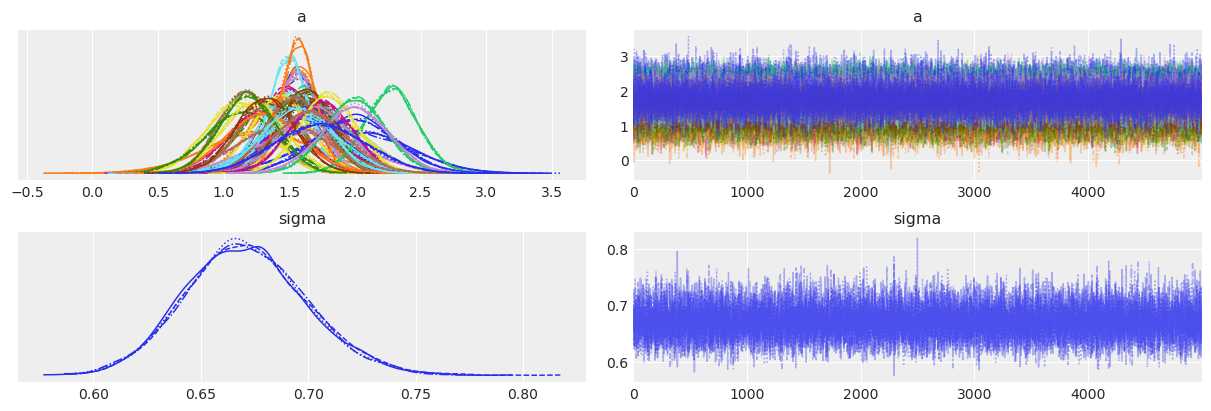

In [190]:
az.plot_trace(inf_data)